|<font size="5">Estimating  Functional  Connectivity</font>|
|----------------------------------------------------------|

In [1]:
import sys
from src.data import subjects
print('Denoising waiting list:\n',subjects.to_construct_correlation)
if subjects.to_construct_correlation == []:
    sys.exit("There is no subject to be denoised!")
sub = subjects.to_construct_correlation[0]
print('Currently processing: subject %s'%sub)

Denoising waiting list:
 []


SystemExit: There is no subject to be denoised!

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
sub = '130S4990' # Subject ID

### Import

In [3]:
from config import *
%matplotlib inline
#%matplotlib notebook
import src.functional_connectivity.functional_connectivity as fc
import os,sys
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import nibabel
from nibabel.gifti.gifti import GiftiImage,GiftiDataArray
import nilearn.plotting
import sklearn.preprocessing
import sklearn.linear_model
import networkx as nx

In [4]:
ts = {}
for ds in denoising_strategies:
    ts[ds] = np.load("%s/ds-%s/sub-%s_ds-%s.npy"
                     %(subjects.time_seriesdir, ds, sub, ds))

# Pearson correlation

Now let's compute the pearson correlation between all parcellations.

In [5]:
correlations = {}
for ct in correlation_types:
    correlations[ct]={}
    for ds in denoising_strategies:
        correlations[ct][ds] = np.corrcoef(ts[ds][:,1:].T)  # drop the zero roi data
        # we end up with a few NAN values because of an empty ROI, for now just zero them out
        correlations[ct][ds][np.isnan(correlations[ct][ds])]=0

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


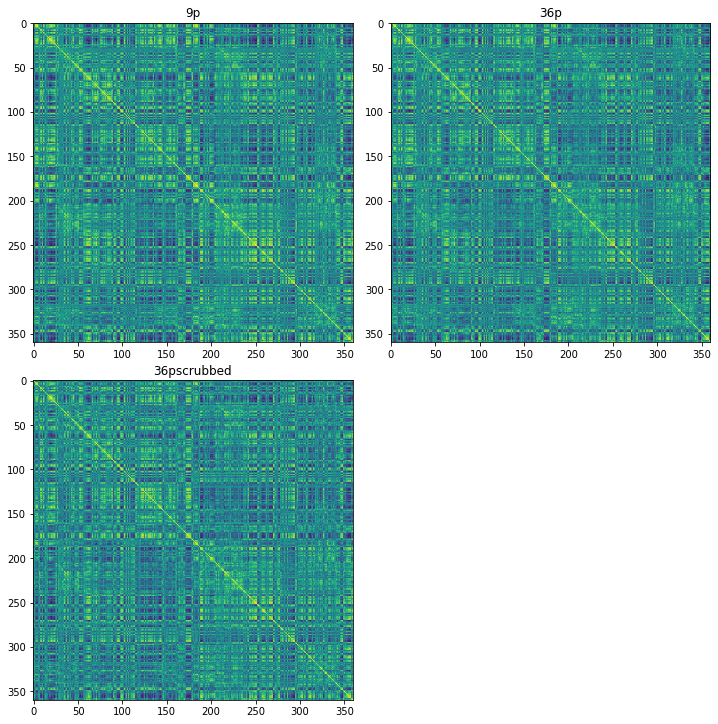

In [6]:
ff = plt.figure(figsize=(10,10))
ax=[]
for i in range(len(denoising_strategies)):
    ax.append(ff.add_subplot((len(denoising_strategies)+1)//2,2,i+1))
for i in range(len(denoising_strategies)):
    ax[i].imshow(correlations['pearson'][denoising_strategies[i]])
    ax[i].title.set_text(denoising_strategies[i])
plt.tight_layout(pad=.5)

It's clear from looking at the data that there is substantial structure in the correlations.  To see this more clearly, let's reorganize the data using the network assignments that were given to the regions on the basis of resting state correlation structurea by Yeo et al. (2011).

In [7]:
atlasdir=rootdir + '/references/HCP-MMP1'

In [8]:
# created previously using get_yeo_assignments.py
labelfile=os.path.join(atlasdir,'MMP_yeo2011_networks.csv')
labeldata=pd.read_csv(labelfile)

In [9]:
#labeldata

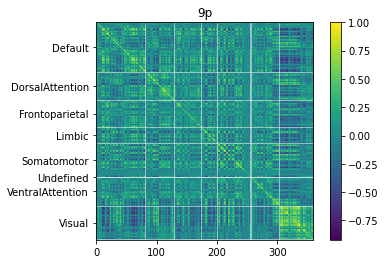

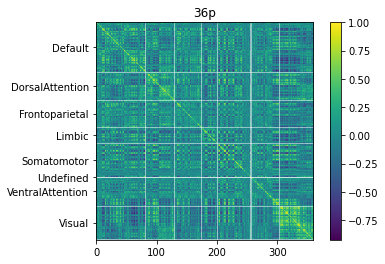

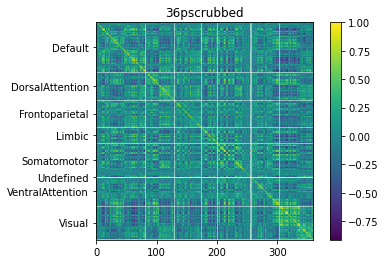

In [15]:
for i in range(len(denoising_strategies)):
    fc.plot_reordered_corrs(correlations['pearson'][denoising_strategies[i]],
                            labeldata,labels='YeoDesc7')
    plt.title(denoising_strategies[i])
    plt.show()

In [12]:
#for i in range(len(denoising_strategies)):
#    f.plot_reordered_corrs(correlations['pearson'][denoising_strategies[i]],labeldata,labels='YeoDesc17')
#    plt.title(denoising_strategies[i])
#    plt.show()

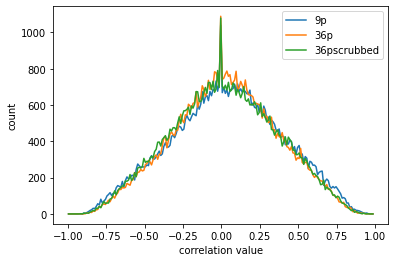

In [16]:
for ds in denoising_strategies:
    hist = np.histogram(correlations['pearson'][ds][np.triu_indices_from(correlations['pearson'][ds],1)],
                        np.arange(-1,1,0.01))
    plt.plot(np.arange(-0.995,0.995,0.01),hist[0])
    plt.xlabel('correlation value')
    plt.ylabel('count')
plt.legend(denoising_strategies) 

In [17]:
ds_couples = [(a,b) for a in denoising_strategies for b in set(denoising_strategies)-{a}]
l = len(denoising_strategies)
ds_couples = ds_couples[0:int(l*(l-1)/2)]
ds_couples

[('9p', '36pscrubbed'), ('9p', '36p'), ('36p', '36pscrubbed')]

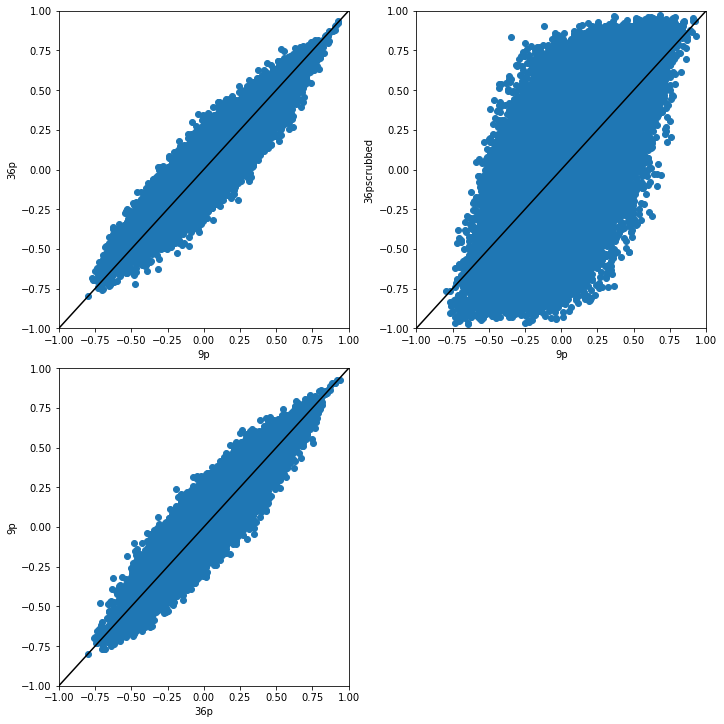

In [15]:
ff = plt.figure(figsize=(10,10))
ax=[]
for i in range(len(ds_couples)):
    ax.append(ff.add_subplot((len(denoising_strategies)+1)//2,2,i+1))
for i in range(len(ds_couples)):
    ax[i].scatter(correlations['pearson'][ds_couples[i][0]][np.triu_indices_from(correlations['pearson'][ds_couples[i][0]],1)],
                  correlations['pearson'][ds_couples[i][1]][np.triu_indices_from(correlations['pearson'][ds_couples[i][1]],1)])
    ax[i].plot([-1,1],[-1,1],'k-')
    ax[i].axis([-1,1,-1,1])
    ax[i].set_xlabel(ds_couples[i][0])
    ax[i].set_ylabel(ds_couples[i][1])
    #ax[i].title.set_text(denoising_strategies[i])
plt.tight_layout(pad=.5)

### Partial correlation

Correlation is sensitive both to direct connections between regions as well as indirect connections. Instead we might be interested in direct connections only, which can be estimated using partial correlation (also known as inverse covariance). Let's estimate that using the graphical lasso technique, which uses L1 regularization that imposes sparsity on the solution.  

In [16]:
for ds in denoising_strategies:
    ts[ds+'_nonzero'] = ts[ds][:,np.arange(ts[ds].shape[1]) !=120 ][:,1:]
ts['36p_nonzero'].shape

(139, 359)

In [17]:
from nilearn import plotting
from inverse_covariance import (
    QuicGraphicalLasso,
    QuicGraphicalLassoCV,
    QuicGraphicalLassoEBIC,
    AdaptiveGraphicalLasso,
)

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [17]:
estimator = QuicGraphicalLasso(init_method='cov', lam=0.07, mode='default', verbose=1)
estimator.fit(ts['36p_nonzero'])

QuicGraphicalLasso(Sigma0=None, Theta0=None, auto_scale=True, init_method='cov',
                   lam=0.07, max_iter=1000, method='quic', mode='default',
                   path=None, score_metric='log_likelihood', tol=1e-06,
                   verbose=1)

In [18]:
ts['36p_nonzero'].shape

(139, 359)

In [19]:
estimator.precision_.shape

(359, 359)

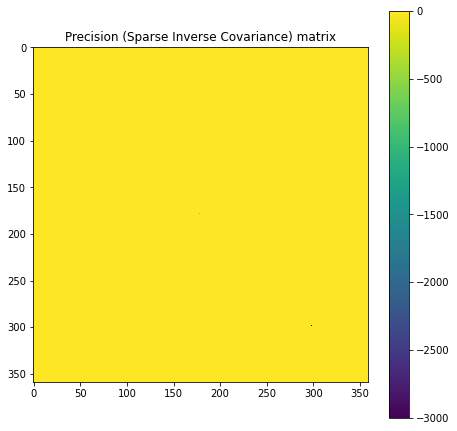

In [20]:
# Display the sparse inverse covariance
plt.figure(figsize=(7.5, 7.5))
plt.imshow(-estimator.precision_, interpolation="nearest")
plt.title('Precision (Sparse Inverse Covariance) matrix')
plt.colorbar()

In [21]:
for i in ["1"]:
    print("\nnumber of positive elements:",
      np.count_nonzero(estimator.precision_ > 0),
      "\nnumber of negative elements:",
      np.count_nonzero(estimator.precision_ < 0),
      "\nthe only elements whit zero values are the diagonal ones:",
      np.count_nonzero(estimator.precision_ == 0),
      "\nvariance:",
      np.var(estimator.precision_),
      "\nquantiles:",
      np.quantile(estimator.precision_,[0,.25, .5, .75,1])
     )


number of positive elements: 2671 
number of negative elements: 5020 
the only elements whit zero values are the diagonal ones: 121190 
variance: 72.89359451450996 
quantiles: [  -3.06244046    0.            0.            0.         3003.23741007]


In [22]:
s = np.shape(ts['36p_nonzero'])[1]
p = s*(s-1)/2
a = np.count_nonzero(estimator.precision_)/2
a/p

0.05984189477287935

In [23]:
import networkx as nx
gr = nx.from_numpy_array(estimator.precision_)
gr_gc = [gr.subgraph(c).copy() for c in nx.connected_components(gr)][0]
print(len(gr_gc.nodes))

357


#### gtgg

In [ ]:
###############################################################################
# Extract and plot sparse inverse covariance

estimator_type = "AdaptiveQuicGraphicalLasso"

if estimator_type == "QuicGraphicalLasso":
    # Compute the sparse inverse covariance via QuicGraphicalLasso
    estimator = QuicGraphicalLasso(
        init_method="cov", lam=0.1, mode="default", verbose=1
    )
    estimator.fit(ts['36p_nonzero'])

elif estimator_type == "QuicGraphicalLassoCV":
    # Compute the sparse inverse covariance via QuicGraphicalLassoCV
    estimator = QuicGraphicalLassoCV(init_method="cov", verbose=1)
    estimator.fit(ts['36p_nonzero'])

elif estimator_type == "QuicGraphicalLassoEBIC":
    # Compute the sparse inverse covariance via QuicGraphicalLassoEBIC
    estimator = QuicGraphicalLassoEBIC(init_method="cov", verbose=1)
    estimator.fit(ts['36p_nonzero'])

elif estimator_type == "AdaptiveQuicGraphicalLasso":
    # Compute the sparse inverse covariance via
    # AdaptiveGraphicalLasso + QuicGraphicalLassoEBIC + method='binary'
    model = AdaptiveGraphicalLasso(
        estimator=QuicGraphicalLassoEBIC(init_method="cov"), method="binary"
    )
    model.fit(ts['36p_nonzero'])
    estimator = model.estimator_

# Display the sparse inverse covariance
plt.figure(figsize=(7.5, 7.5))
plt.imshow(
    np.triu(-estimator.precision_, 1), interpolation="nearest", cmap=plt.cm.RdBu_r
)
plt.title("Precision (Sparse Inverse Covariance) matrix")
plt.colorbar()

s = np.shape(ts['36p_nonzero'])[1]
p = s*(s-1)/2
a = np.count_nonzero(estimator.precision_)/2
gr = nx.from_numpy_array(estimator.precision_)
gr_gc = [gr.subgraph(c).copy() for c in nx.connected_components(gr)][0]

print("\nnumber of positive elements:",
      np.count_nonzero(estimator.precision_ > 0),
      "\nnumber of negative elements:",
      np.count_nonzero(estimator.precision_ < 0),
      "\nthe only elements whit zero values are the diagonal ones:",
      np.count_nonzero(estimator.precision_ == 0),
      "\nvariance:",
      np.var(estimator.precision_),
      "\nquantiles:",
      np.quantile(estimator.precision_,[0,.25, .5, .75,1]),
      '\ndensity:',a/p,
      '\ngc size:',len(gr_gc.nodes)
      )

#### QuicGraphLassoCV

In [ ]:
model = QuicGraphLassoCV(init_method='cov', verbose=1)
model.fit(ts['36p_nonzero'])        # X is data matrix (n_samples, n_features) 

In [ ]:
imshow(correlations['pearson'][denoising_strategies[i]])

In [ ]:
# Display the sparse inverse covariance
plt.figure(figsize=(7.5, 7.5))
plt.imshow(-model.precision_, interpolation="nearest")
plt.title('Precision (Sparse Inverse Covariance) matrix')
plt.colorbar()

### Export

In [19]:
for ds in denoising_strategies:
    for ct in correlations:
        np.save("%s/data/04_correlations/corr-%s/ds-%s/sub-%s_ds-%s_corr-%s"
                %(rootdir,ct,ds,sub,ds,ct),correlations[ct][ds])
        Gr=nx.from_numpy_array(correlations[ct][ds])
        nx.write_gexf(Gr,"%s/data/04_correlations/corr-%s/ds-%s/sub-%s_ds-%s_corr-%s.gexf"
                      %(rootdir,ct,ds,sub,ds,ct))

In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint()

In [ ]:
%%javascript
Jupyter.notebook.save_notebook()

In [ ]:
#os.system("cp %sconnectivity_derivs/codes/Pipeline/04_estimating_functional_connectivity.ipynb /home/alireza/Thesis/Databases/ADNI/connectivity_derivs/codes/Denoising/sub-%s_functional_connectivity.ipynb"%(workdir,sub))

### Compute functional connectivity for all subjects

In [ ]:
fc.all_pearsons(subjects.to_construct_correlation)

processing sub-011S4547


/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


processing sub-037S4706
processing sub-041S4513
processing sub-068S2315
processing sub-002S4473
processing sub-041S4974
processing sub-094S2201
processing sub-137S4351
processing sub-137S4536
processing sub-012S4987
processing sub-137S4299
processing sub-082S2121
processing sub-068S2184
processing sub-068S4431
processing sub-012S4188
